In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
from pycoingecko import CoinGeckoAPI
import requests
import json
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Conv1D, Flatten, Dropout
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional
import seaborn as sns
import csv

## Parameters

In [39]:
# number of top uniswap pools based on volumeUSD which you wnat to consider for LM incentives
uniswap_n_pools=20
# Number of previous to extract data 
uniswap_n_days=90 
# Additional ROI to set targeted roi in calculation of incentives   
surplus_factor = 0 
# correction in baseline roi which to calculate targeted tvl
correction_factor=0.0015
#Should be equal to data points available in during period (For LSTM Model input and output shape) 
tw=23 
optimism_n_days=300
optimism_url='https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis'
uniswap_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'
optimism_pool_ids=["0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86","0x1c3140ab59d6caf9fa7459c6f83d4b52ba881d36","0xbf16ef186e715668aa29cef57e2fd7f9d48adfe6","0x03af20bdaaffb4cc0a521796a223f7d85e2aac31" ]
# Incentive duartion of uniswap optimism pools
incentive_start_date = pd.to_datetime('2023-01-24') 
incentive_end_date = pd.to_datetime('2023-02-15') 


## Get Ids of Top Uniswap n_pools based on VolumeUSD

In [3]:
def get_uniswap_pools(n_pools):
    url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

    # GraphQL query to fetch the pool id and daily volume for the top n_pools
    query = """
    {{
      pools(first: {0}, orderBy: volumeUSD, orderDirection: desc) {{
        id
        volumeUSD
      }}
    }}
    """.format(n_pools)

    # Make the request
    response = requests.post(url, json={'query': query})

    # Get the JSON data from the response
    data = json.loads(response.text)

    # Get the pool IDs from the data
    pool_ids = [pool['id'] for pool in data['data']['pools']]

    return pool_ids

In [4]:
uniswap_pool_ids=get_uniswap_pools(uniswap_n_pools)
uniswap_pool_ids

['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
 '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
 '0x11b815efb8f581194ae79006d24e0d814b7697f6',
 '0x3416cf6c708da44db2624d63ea0aaef7113527c6',
 '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',
 '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
 '0x60594a405d53811d3bc4766596efd80fd545a270',
 '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
 '0x5777d92f208679db4b9778590fa3cab3ac9e2168',
 '0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf',
 '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35',
 '0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8',
 '0xe0554a476a092703abdb3ef35c80e0d76d32939f',
 '0x6c6bc977e13df9b0de53b251522280bb72383700',
 '0xac4b3dacb91461209ae9d41ec517c2b9cb1b7daf',
 '0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26',
 '0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011',
 '0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8',
 '0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5',
 '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801']

## Get Daily Data (tvlUSD,volumeUSD,feesUSD,liquidity) of Uniswap pools of n_days

In [5]:
def get_uniswap_pool_daily_data(pool_id, number_of_days,url):
    url=url
    query = f"""
    {{
        poolDayDatas(where: {{ pool: "{pool_id}" }}, first: {number_of_days}, orderBy: date, orderDirection: desc) {{
            date
            sqrtPrice
            liquidity
            volumeUSD
            tvlUSD
            feesUSD
            pool {{
                token0 {{
                    symbol
                }}
                token1 {{
                    symbol
                }}
                feeTier
            }}
        }}
    }}
    """
    response = requests.post(url, json={'query': query})
    data = response.json()
    
    for poolDayData in data['data']['poolDayDatas']:
        poolDayData['pool_name'] = poolDayData['pool']['token0']['symbol'] + "/" + poolDayData['pool']['token1']['symbol'] + "(" + str(poolDayData['pool']['feeTier']) + ")"
        poolDayData['feesUSD'] = float(poolDayData['feesUSD'])
        poolDayData['tvlUSD'] = float(poolDayData['tvlUSD'])
        poolDayData['volumeUSD'] = float(poolDayData['volumeUSD'])
        poolDayData['date'] = pd.to_datetime(poolDayData['date'], unit='s')

    return data['data']['poolDayDatas']

def get_uniswap_pools_daily_data(pool_ids,days,url):
    uniswap_pools_daily_data={}
    for pool_id in pool_ids:
        uniswap_data = get_uniswap_pool_daily_data(pool_id, days,url)
        df = pd.DataFrame(uniswap_data)
        df.drop('pool', axis=1, inplace=True)
        uniswap_pools_daily_data[pool_id] = df
    return uniswap_pools_daily_data

In [6]:
uniswap_pools_daily_data=get_uniswap_pools_daily_data(uniswap_pool_ids,uniswap_n_days,uniswap_url)

uniswap_pools_daily_data[uniswap_pool_ids[0]].head(10)

,date,sqrtPrice,liquidity,volumeUSD,tvlUSD,feesUSD,pool_name
0,2023-07-30,1828872976955916977689884181869172,40432603643394868334,1.956707e+07,4.551027e+08,9783.536402,USDC/WETH(500)
1,2023-07-29,1826917299307074920752451863881525,30200461617431634523,4.368230e+07,4.542601e+08,21841.147838,USDC/WETH(500)
2,2023-07-28,1829791576617039129611696526557863,37801870352356681082,7.118041e+07,4.545924e+08,35590.206493,USDC/WETH(500)
3,2023-07-27,1837191205785788284635762034160882,35441494483952010926,1.287038e+08,4.521174e+08,64351.896535,USDC/WETH(500)
4,2023-07-26,1831824653561120358233817973080686,33806726588067894535,1.913512e+08,4.535568e+08,95675.587288,USDC/WETH(500)
5,2023-07-25,1838165034318148718324741682696877,32654731931946478883,9.291605e+07,4.500665e+08,46458.024026,USDC/WETH(500)
6,2023-07-24,1842137682782003074567989297132856,28983827767533051385,1.880133e+08,4.519792e+08,94006.652794,USDC/WETH(500)
7,2023-07-23,1823342136037211281424014263837641,36724937881999124033,9.623028e+07,4.562015e+08,48115.137951,USDC/WETH(500)
8,2023-07-22,1834030979989323292917161038459059,31910517471171033155,1.147339e+08,4.531865e+08,57366.927100,USDC/WETH(500)
9,2023-07-21,1821395791154592514214103033330937,40243892839276545027,1.115282e+08,4.569025e+08,55764.082122,USDC/WETH(500)


## Compute pool Matrice (feesUSD/tvlUSD)
This function calculates and summarizes key performance indicators for each pool in the Uniswap data. These metrics include the exponentially weighted moving average (EWMA) of fees, total value locked (TVL), and daily volume. The EWMA gives more weight to recent data points, making it more responsive to changes. The function also calculates daily, monthly, and annual return on investment (ROI) based on these values. The results are compiled into a DataFrame for easy analysis and comparison.

In [7]:
def calculate_pool_matrices(uniswap_pools_daily_data):
    results = {}
    for pool_id, df in uniswap_pools_daily_data.items():
        
        df = df[(df['feesUSD'] != 0) & (df['tvlUSD'] != 0) & df['feesUSD'].notna() & df['tvlUSD'].notna()]
        
        pool_name = df['pool_name'].iloc[0]
        avg_feeUSD = df['feesUSD'].ewm(span=30).mean().iloc[-1]
        avg_tvl = df['tvlUSD'].ewm(span=30).mean().iloc[-1]
        
        adv = df['volumeUSD'].ewm(span=30).mean().iloc[-1]

        daily_roi = (df['feesUSD'] /df['tvlUSD']).ewm(span=30).mean().iloc[-1]
        monthly_roi = ((1 + daily_roi)**30) - 1
        annual_roi = ((1 + daily_roi)**365) - 1
       
        results[pool_id] = {'pool_name':pool_name,'avg_feesUSD': avg_feeUSD, 'avg_tvlUSD': avg_tvl, 'adv': adv, 'daily_roi': daily_roi,'monthly_roi':monthly_roi,'annual_roi':annual_roi}
    df_rois_uniswap = pd.DataFrame.from_dict(results, orient='index')
    return df_rois_uniswap

In [8]:
df_pool_matrices=calculate_pool_matrices(uniswap_pools_daily_data)
df_pool_matrices

,pool_name,avg_feesUSD,avg_tvlUSD,adv,daily_roi,monthly_roi,annual_roi
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC/WETH(500),112826.222639,4.472081e+08,2.256524e+08,2.530814e-04,0.007620,0.096763
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC/WETH(3000),27694.939323,2.804378e+08,9.231646e+06,9.928210e-05,0.002983,0.036901
0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH/USDT(500),36849.094254,9.141482e+07,7.369819e+07,4.044723e-04,0.012206,0.159052
0x3416cf6c708da44db2624d63ea0aaef7113527c6,USDC/USDT(100),9604.608128,8.398179e+07,9.604608e+07,1.212219e-04,0.003643,0.045237
0x4585fe77225b41b697c938b018e2ac67ac5a20c0,WBTC/WETH(500),16358.440220,1.215173e+08,3.271688e+07,1.350181e-04,0.004058,0.050513
0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH/USDT(3000),15905.744237,1.314819e+08,5.301915e+06,1.212605e-04,0.003644,0.045251
0x60594a405d53811d3bc4766596efd80fd545a270,DAI/WETH(500),4878.800057,1.858864e+07,9.757600e+06,2.638946e-04,0.007947,0.101099
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,WBTC/WETH(3000),25325.055429,2.832811e+08,8.441685e+06,8.923572e-05,0.002681,0.033106
0x5777d92f208679db4b9778590fa3cab3ac9e2168,DAI/USDC(100),1395.457386,1.094057e+08,1.395457e+07,1.273950e-05,0.000382,0.004661
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC/USDT(500),1017.413574,1.768922e+07,2.034827e+06,5.492990e-05,0.001649,0.020251


## Define Baseline ROI
This code cell calculates the baseline return on investment (ROI) to be used for comparison with other pools. It first computes the average monthly ROI and average daily volume (adv) from the previously calculated pool matrices. It then defines the baseline ROI as the average monthly ROI adjusted by a correction factor. This baseline ROI serves as a reference point for evaluating the performance of different pools.

In [9]:
avg_monthly_roi=df_pool_matrices['monthly_roi'].mean()
avg_adv=df_pool_matrices['adv'].mean() 
baseline_roi=avg_monthly_roi-correction_factor
baseline_roi

0.003270794331801176

## Filter Pools
This code cell filters out the pools that are already performing above the baseline return on investment (ROI). The rationale here is that pools that are already performing well may not benefit significantly from additional incentives. The function returns the list of pool IDs and data for the pools that have a monthly ROI less than the baseline ROI. This filtered set of pools will be used for further analysis and possibly for liquidity mining incentives. 

In [10]:
def filter_pools(baseline_roi,df_pool_matrices):
    filtered_pools_df = df_pool_matrices[df_pool_matrices['monthly_roi'] < baseline_roi]
    filtered_pool_ids = filtered_pools_df.index.tolist()
    
    return filtered_pool_ids,filtered_pools_df

In [11]:
filtered_pool_ids,filtered_pools_df=filter_pools(baseline_roi,df_pool_matrices)
filtered_pools_df

,pool_name,avg_feesUSD,avg_tvlUSD,adv,daily_roi,monthly_roi,annual_roi
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC/WETH(3000),27694.939323,2.804378e+08,9.231646e+06,9.928210e-05,0.002983,0.036901
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,WBTC/WETH(3000),25325.055429,2.832811e+08,8.441685e+06,8.923572e-05,0.002681,0.033106
0x5777d92f208679db4b9778590fa3cab3ac9e2168,DAI/USDC(100),1395.457386,1.094057e+08,1.395457e+07,1.273950e-05,0.000382,0.004661
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC/USDT(500),1017.413574,1.768922e+07,2.034827e+06,5.492990e-05,0.001649,0.020251
0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,DAI/WETH(3000),5011.745362,4.652558e+07,1.670582e+06,1.079079e-04,0.003242,0.040170
0xe0554a476a092703abdb3ef35c80e0d76d32939f,USDC/WETH(100),5.410061,1.251895e+06,5.410061e+04,4.377685e-06,0.000131,0.001599
0x6c6bc977e13df9b0de53b251522280bb72383700,DAI/USDC(500),468.438320,6.589392e+07,9.368766e+05,7.110772e-06,0.000213,0.002599
0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,FEI/USDC(500),0.306727,3.105674e+06,6.134533e+02,9.876236e-08,0.000003,0.000036
0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011,WETH/LOOKS(3000),708.354342,9.199308e+06,2.361181e+05,7.787596e-05,0.002339,0.028831
0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5,HEX/USDC(3000),1003.700457,1.004438e+07,3.345668e+05,9.797780e-05,0.002944,0.036407


## Predict Estimated tvlUSD of filtered pools based on their Historic data
This code cell defines a function for estimating the Total Value Locked (TVL) for each pool in the filtered set, using the AutoRegressive Integrated Moving Average (ARIMA) model. 

The function takes in the daily data for each pool, the list of filtered pool IDs, and the order of the ARIMA model as arguments. It then fits the ARIMA model to the TVL data of each pool and makes forecasts for the next 30 days. 

The mean forecasted TVL for each pool is then stored in a DataFrame, which is returned by the function. This DataFrame provides an estimate of each pool's TVL for the next 30 days, which can be used to evaluate the potential impact of the liquidity mining incentives.

In [12]:
def estimated_tvl_model(uniswap_pools_daily_data, filtered_pool_ids, order=(1, 2, 3), forecast_steps=30):
    estimated_tvl = []

    # Loop over the pool IDs
    for pool_id in filtered_pool_ids:
        # Get the TVL data for the current pool
        df = uniswap_pools_daily_data[pool_id]
        tvl_data = df['tvlUSD'].astype(float)

        # Define and fit the model
        model = ARIMA(tvl_data, order=order)
        model_fit = model.fit()

        # Make forecasts
        forecasts = model_fit.forecast(steps=forecast_steps)

        # Save the pool id and mean forecast to the list
        estimated_tvl.append({
            'pool_id': pool_id,
            'estimated_tvl': forecasts.mean()
        })

    # Convert the list to a DataFrame
    df_estimated_tvl = pd.DataFrame(estimated_tvl)

    # Set 'pool_id' as the index
    df_estimated_tvl.set_index('pool_id', inplace=True)

    # Return the DataFrame of estimated TVLs
    return df_estimated_tvl


In [13]:
estimated_tvl_df = estimated_tvl_model(uniswap_pools_daily_data,filtered_pool_ids, order=(1, 2, 3), forecast_steps=30)
estimated_tvl_df

c:\Users\hijaz tr\Desktop\cadCADProject1\abcde\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hijaz tr\Desktop\cadCADProject1\abcde\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\hijaz tr\Desktop\cadCADProject1\abcde\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hijaz tr\Desktop\cadCADProject1\abcde\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hijaz tr\Desktop\cadCADProject1\abcde\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\hijaz tr\Desktop\cadCADProject1\abcde\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,estimated_tvl
pool_id,
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,3.079180e+08
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,3.223544e+08
0x5777d92f208679db4b9778590fa3cab3ac9e2168,1.095404e+08
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,2.288200e+07
0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,5.730854e+07
0xe0554a476a092703abdb3ef35c80e0d76d32939f,1.678269e+06
0x6c6bc977e13df9b0de53b251522280bb72383700,6.594319e+07
0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,3.099190e+06
0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011,1.121969e+07


## Calcualte Incentives For filtered Pools
This cell calculates the incentives required for each pool to reach the target ROI. It does this by comparing the current ROI to the target, and then proportionally distributing the incentives based on the estimated future TVL of each pool.

In [14]:
def calculate_incentive_allocation(baseline_roi, current_roi, surplus_factor, estimated_tvl):
    
    targeted_roi = baseline_roi + surplus_factor
    difference = targeted_roi - current_roi

    incentive_allocation = difference * estimated_tvl
    return incentive_allocation

def calculate_incentives(baseline_roi,filtered_pools_df,filtered_pool_ids,estimated_tvl_df):
    incentive_allocations = []
    for pool_id in filtered_pool_ids:
        df = uniswap_pools_daily_data[pool_id]

        estimated_tvl = estimated_tvl_df.loc[pool_id,'estimated_tvl']
        current_roi = filtered_pools_df.loc[pool_id, 'monthly_roi']
        incentive_allocation = calculate_incentive_allocation(baseline_roi, current_roi, surplus_factor, estimated_tvl)
        incentive_allocations.append({
            'pool_id': pool_id,
            'incentive_allocation': incentive_allocation
        })

    df_incentives = pd.DataFrame(incentive_allocations)
    df_incentives.set_index('pool_id', inplace=True)
    
    return df_incentives

In [15]:
df_incentives=calculate_incentives(baseline_roi,filtered_pools_df,filtered_pool_ids,estimated_tvl_df)
df_incentives

,incentive_allocation
pool_id,
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,88692.568087
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,190271.581815
0x5777d92f208679db4b9778590fa3cab3ac9e2168,316411.683890
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,37105.096138
0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,1632.524298
0xe0554a476a092703abdb3ef35c80e0d76d32939f,5268.850107
0x6c6bc977e13df9b0de53b251522280bb72383700,201617.946803
0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,10127.630593
0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011,10455.354302


In [16]:
df_incentives['incentive_allocation'].sum()

864724.3338088578

## Target tvl Model
This cell calculates the target TVL for each pool. The target TVL is the future TVL that each pool should aim for to reach the target ROI. The target TVL is calculated by adjusting the estimated TVL based on the ratio of the target ROI to the current ROI.

In [17]:
def target_tvl_model(baseline_roi, filtered_pools_df, filtered_pool_ids,estimated_tvl_df):
    target_tvl_values = []
    for pool_id in filtered_pool_ids:
        
        current_roi = filtered_pools_df.loc[pool_id, 'monthly_roi']
      
        estimated_tvl = estimated_tvl_df.loc[pool_id,'estimated_tvl']
    
        # Calculate the ratio of the target ROI to the current ROI
        roi_ratio = baseline_roi / current_roi if current_roi != 0 else 0

        # Calculate the target TVL by adjusting the current TVL based on the ROI ratio
        target_tvl = (estimated_tvl * roi_ratio)

        target_tvl_values.append({
            'pool_id': pool_id,
            'target_tvl': target_tvl
        })

    df_target_tvl = pd.DataFrame(target_tvl_values)
    df_target_tvl.set_index('pool_id', inplace=True)
    return df_target_tvl

In [18]:
df_target_tvl = target_tvl_model(baseline_roi, filtered_pools_df, filtered_pool_ids,estimated_tvl_df)
df_target_tvl

,target_tvl
pool_id,
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,3.376531e+08
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,3.933370e+08
0x5777d92f208679db4b9778590fa3cab3ac9e2168,9.372891e+08
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,4.538071e+07
0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,5.781205e+07
0xe0554a476a092703abdb3ef35c80e0d76d32939f,4.179472e+07
0x6c6bc977e13df9b0de53b251522280bb72383700,1.010975e+09
0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,3.421276e+09
0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011,1.568986e+07


In [19]:
resultant_df = pd.concat([filtered_pools_df, df_incentives, df_target_tvl, estimated_tvl_df], axis=1)
resultant_df

,pool_name,avg_feesUSD,avg_tvlUSD,adv,daily_roi,monthly_roi,annual_roi,incentive_allocation,target_tvl,estimated_tvl
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC/WETH(3000),27694.939323,2.804378e+08,9.231646e+06,9.928210e-05,0.002983,0.036901,88692.568087,3.376531e+08,3.079180e+08
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,WBTC/WETH(3000),25325.055429,2.832811e+08,8.441685e+06,8.923572e-05,0.002681,0.033106,190271.581815,3.933370e+08,3.223544e+08
0x5777d92f208679db4b9778590fa3cab3ac9e2168,DAI/USDC(100),1395.457386,1.094057e+08,1.395457e+07,1.273950e-05,0.000382,0.004661,316411.683890,9.372891e+08,1.095404e+08
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC/USDT(500),1017.413574,1.768922e+07,2.034827e+06,5.492990e-05,0.001649,0.020251,37105.096138,4.538071e+07,2.288200e+07
0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,DAI/WETH(3000),5011.745362,4.652558e+07,1.670582e+06,1.079079e-04,0.003242,0.040170,1632.524298,5.781205e+07,5.730854e+07
0xe0554a476a092703abdb3ef35c80e0d76d32939f,USDC/WETH(100),5.410061,1.251895e+06,5.410061e+04,4.377685e-06,0.000131,0.001599,5268.850107,4.179472e+07,1.678269e+06
0x6c6bc977e13df9b0de53b251522280bb72383700,DAI/USDC(500),468.438320,6.589392e+07,9.368766e+05,7.110772e-06,0.000213,0.002599,201617.946803,1.010975e+09,6.594319e+07
0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,FEI/USDC(500),0.306727,3.105674e+06,6.134533e+02,9.876236e-08,0.000003,0.000036,10127.630593,3.421276e+09,3.099190e+06
0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011,WETH/LOOKS(3000),708.354342,9.199308e+06,2.361181e+05,7.787596e-05,0.002339,0.028831,10455.354302,1.568986e+07,1.121969e+07
0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5,HEX/USDC(3000),1003.700457,1.004438e+07,3.345668e+05,9.797780e-05,0.002944,0.036407,3141.097776,1.066469e+07,9.597563e+06


In [20]:
def get_all_data():
    uniswap_data_list = []
    optimism_data_list = []

    for pool_id in filtered_pool_ids:
        uniswap_pool_data = uniswap_pools_daily_data[pool_id]
        uniswap_pool_data = uniswap_pool_data['tvlUSD'].values[:tw]
        uniswap_data_list.append(uniswap_pool_data)

    for pool_id in optimism_pool_ids:
        optimism_pool_data = optimism_pools_daily_data[pool_id]
        optimism_pool_data = optimism_pool_data['tvlUSD'].values[:tw]
        optimism_data_list.append(optimism_pool_data)

    # Flatten the lists and concatenate them
    all_data_list = np.concatenate(uniswap_data_list + optimism_data_list)
    return all_data_list

# TVL Growth Model
Get the training data to model tvl growth
Use optimism Uniswap V3 pools which were incentivized by LM incentives to train model 

## Get training data of optimism uniswap pools
This code block is responsible for loading and preparing the training data for the TVL growth model. The training data consists of historical TVL information from incentivized Uniswap V3 pools on the Optimism network. The data is divided into three parts: before, during, and after the incentive period. This allows the model to learn from the different states of a pool with respect to liquidity mining incentives.

In [21]:
def load_training_data(training_data):
    
    training_df = training_data
    # Extract and prepare traning data

    training_df_before = training_df[training_df['date'] < incentive_start_date]
    training_df_during = training_df[(training_df['date'] >= incentive_start_date) & (training_df['date'] <= incentive_end_date)]
    training_df_after = training_df[training_df['date'] > incentive_end_date]
    
    return training_df_before,training_df_during,training_df_after

optimism_pools_daily_data=get_uniswap_pools_daily_data(optimism_pool_ids,optimism_n_days,optimism_url)
training_df_before, training_df_during, training_df_after = load_training_data(optimism_pools_daily_data[optimism_pool_ids[training_pool_id]])

## Prepare Training data for LSTM model
This code block prepares the training data for the TVL growth model. It uses a window-based approach where the model looks at a certain number of previous time steps (the time window) to predict the TVL growth for the next time step. The data is scaled using the MinMaxScaler to ensure that the LSTM model can effectively learn from the data. The function returns the training data and corresponding labels (TVL values), along with the scaler objects used for each pool.

In [22]:
# Without scaling data
def prepare_training_data(tw, pool_ids, pools_daily_data):
    X_train_list = []
    y_train_list = []
    
    for pool_id in pool_ids:
        training_df_before, training_df_during, _ = load_training_data(pools_daily_data[pool_id])
        X_train_data = training_df_before
        y_train_data = training_df_during


        X_train = X_train_data['tvlUSD'].iloc[::-1].values[-tw:]
        y_train = y_train_data['tvlUSD'].iloc[::-1].values[:tw]
        

        X_train = X_train.reshape((1, tw, 1))
        y_train = y_train.reshape((1, tw, 1))

        X_train_list.append(X_train)
        y_train_list.append(y_train)
    

    X_train_all = np.concatenate(X_train_list, axis=0)
    y_train_all = np.concatenate(y_train_list, axis=0)

    return X_train_all, y_train_all

# Global scaler
def prepare_training_data_scaled(tw, pool_ids, pools_daily_data):
    X_train_list = []
    y_train_list = []

    for pool_id in pool_ids:
        training_df_before, training_df_during, _ = load_training_data(pools_daily_data[pool_id])
        X_train_data = training_df_before
        y_train_data = training_df_during

        X_train = X_train_data['tvlUSD'].iloc[::-1].values[-tw:]
        y_train = y_train_data['tvlUSD'].iloc[::-1].values[:tw]
        
        X_train = X_train.reshape((1, tw, 1))
        y_train = y_train.reshape((1, tw, 1))

        X_train_list.append(X_train)
        y_train_list.append(y_train)

    X_train_all = np.concatenate(X_train_list, axis=0)
    y_train_all = np.concatenate(y_train_list, axis=0)

    # Reshape to 2D
    X_train_all_2d = X_train_all.reshape(X_train_all.shape[0]*X_train_all.shape[1], X_train_all.shape[2])
    y_train_all_2d = y_train_all.reshape(y_train_all.shape[0]*y_train_all.shape[1], y_train_all.shape[2])

    # Scale all training data together
    scaler_all = MinMaxScaler()
    all_train_data = np.concatenate([X_train_all_2d, y_train_all_2d], axis=0)
    scaler_all.fit(all_train_data)

    # Transform the training data
    X_train_all = scaler_all.transform(X_train_all_2d).reshape(X_train_all.shape)
    y_train_all = scaler_all.transform(y_train_all_2d).reshape(y_train_all.shape)

    return X_train_all, y_train_all, scaler_all

## Prepare test data to feed to model for prediction
This cell contains a function that prepares the test data for the TVL growth model. The function takes in the TVL data of a specific pool (the test data) and a time window. It scales the TVL data using MinMaxScaler to a range between 0 and 1, which is a common practice when working with neural networks as it can improve the model's performance. The function then reshapes the data into a format suitable for the LSTM model, which expects input in the form of 3-dimensional arrays with the dimensions representing the batch size, the number of time steps, and the number of features, respectively. The function returns the prepared test sequence and the scaler that was used to transform the data.

In [23]:
def prepare_test_data(test_data, tw):
    
    df_test_data=test_data

    test_sequence = df_test_data['tvlUSD'].iloc[::-1].values[-tw:]

    # Reshape the data for the LSTM
    test_sequence = test_sequence.reshape((1, tw, 1))
    
    return test_sequence

def prepare_test_data_scaled(test_data, tw):
    
    df_test_data=test_data

    test_sequence = df_test_data['tvlUSD'].iloc[::-1].values[-tw:]

    test_sequence = scaler_all.transform(test_sequence.reshape(-1, 1))

    # Reshape the data for the LSTM
    test_sequence = test_sequence.reshape((1, tw, 1))
    
    return test_sequence

In [24]:
def plot_predicted_tvl(predicted_tvl, target_tvl, current_tvl, incentives, pool_name):
    import matplotlib.pyplot as plt

    # Since 'predicted_tvl' is a 2D array, we need to flatten it to a 1D array for plotting
    predicted_tvl = predicted_tvl.flatten()

    # Create a sequence of numbers from 0 to the length of data_flat - 1
    x_values = range(len(predicted_tvl))

    # Create the plot
    plt.figure(figsize=(8, 4))  # Increase the size of the plot
    plt.plot(x_values, predicted_tvl, marker='o', linestyle='-', color='b', linewidth=2.0, label='Predicted TVL')  # Plot the data
    plt.axhline(y=target_tvl, color='r', linestyle='--', linewidth=2.0, label='Target TVL')  # Add a horizontal line at the target TVL
    plt.axhline(y=current_tvl, color='g', linestyle='--', linewidth=2.0, label='Current TVL')  # Add a horizontal line at the current TVL

    # Add labels and title
    plt.xlabel('Time Steps', fontsize=10)
    plt.ylabel('TVL (in USD)', fontsize=10)
    plt.title('TVL Growth Model for ' + pool_name + ' with Incentives Allocation of ' + str(int(incentives))+' USD', fontsize=12)

    # Add a legend
    plt.legend(loc='upper left', fontsize=6)

    # Display the plot
    plt.grid(True)
    plt.show()

## Model Architecture
This code block defines the architecture for the TVL growth model. The model is a simple LSTM network which consists of a single LSTM layer followed by a dense layer. The LSTM layer takes the time series data of TVL and uses 5 hidden units to capture the temporal dependencies in the data. The Dense layer is the output layer of the model which produces the predicted TVL for the next time window. The model uses the mean squared error (MSE) loss function which is suitable for regression tasks and is compiled with the Adam optimizer.

In [41]:
def create_model(time_window):
    model = Sequential()
    
    # Single LSTM layer with 50 units
    model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(time_window,1)))

    # Output layer
    model.add(Dense(tw, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model


def create_model1(time_window):
    model = Sequential()
    
    # Single LSTM layer with 50 units
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(time_window,1)))

    # Output layer
   
    model.add(Dense(1, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model


def create_model2(time_window):
    model = Sequential()
    
    # Single LSTM layer with 50 units
    model.add(LSTM(5, activation='relu', return_sequences=False, input_shape=(time_window,1), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    
    # Dropout layer
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(tw, activation='relu'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model

def create_model3(time_window):
    model = Sequential()
    
    # Single LSTM layer with 50 units
    model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(time_window,1), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    
    # Dropout layer
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1, activation='relu'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model

def create_model4(time_window):
    model = Sequential()
    
    # Conv1D layer
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_window, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Bidirectional LSTM layer with dropout for regularization
    model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.5)))

    # Another Conv1D layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten layer to flat the output for Dense layer
    model.add(Flatten())

    # Dense layer with dropout
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(tw, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model


## Train Model
This code block is responsible for training the Total Value Locked (TVL) growth model. The model is trained on the prepared training data consisting of TVL time series data from multiple liquidity pools. The training is conducted over 150 epochs. Since the model is expected to predict the TVL growth, a regression model architecture is used. The LSTM-based model, which was defined in the previous cell, is used here. LSTM, or Long Short-Term Memory, is a type of recurrent neural network that is well-suited to learning from time series data like the one we have here. It's worth noting that the model is trained without any validation data.

In [31]:
# 1. Scaled model 4
# 2. Unscaled model 1

In [32]:
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# Use scaled data to trian model
#X_train_all, y_train_all,scaler_all=prepare_training_data_scaled(tw, optimism_pool_ids, optimism_pools_daily_data)

#Use unscaled data to train model
X_train_all, y_train_all=prepare_training_data(tw, optimism_pool_ids, optimism_pools_daily_data)

model = create_model1(tw)
model.fit(X_train_all, y_train_all, epochs=150, verbose=1, validation_split=0)#, callbacks=[earlystop])

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 38701732200448.0000
Epoch 2/150
1/1 [==============================] - 0s 14ms/step - loss: 38564591042560.0000
Epoch 3/150
1/1 [==============================] - 0s 15ms/step - loss: 38525969891328.0000
Epoch 4/150
1/1 [==============================] - 0s 19ms/step - loss: 38750885249024.0000
Epoch 5/150
1/1 [==============================] - 0s 18ms/step - loss: 38621587439616.0000
Epoch 6/150
1/1 [==============================] - 0s 22ms/step - loss: 38487839473664.0000
Epoch 7/150
1/1 [==============================] - 0s 19ms/step - loss: 38802177392640.0000
Epoch 8/150
1/1 [==============================] - 0s 22ms/step - loss: 38196725415936.0000
Epoch 9/150
1/1 [==============================] - 0s 16ms/step - loss: 38357992210432.0000
Epoch 10/150
1/1 [==============================] - 0s 15ms/step - loss: 38298965770240.0000
Epoch 11/150
1/1 [==============================] - 0s 19ms/step - loss: 38338484

## Make predictions on filtered uniswap pools
In this cell, we're utilizing the trained TVL growth model to predict the future TVL values for each of the underperforming pools identified earlier. These predictions are then inverse scaled back to their original scale to interpret them in terms of TVL. We also calculate the mean predicted TVL for each pool. The cell plots the predicted TVL values for each pool along with the target TVL, current TVL, and incentives. Finally, the cell combines all the relevant data for each pool into a single dataframe, including the calculated incentive allocation, target TVL, estimated TVL, and mean predicted TVL.

1/1 [==============================] - 0s 257ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


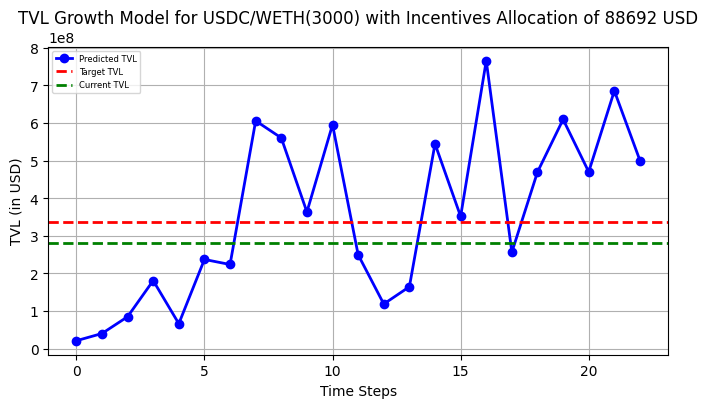

1/1 [==============================] - 0s 51ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


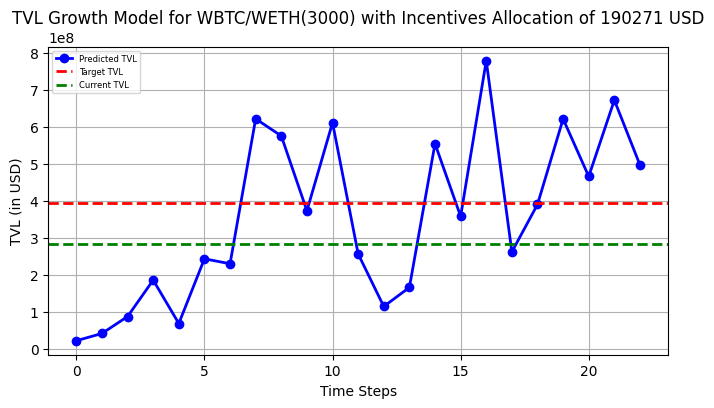

1/1 [==============================] - 0s 36ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


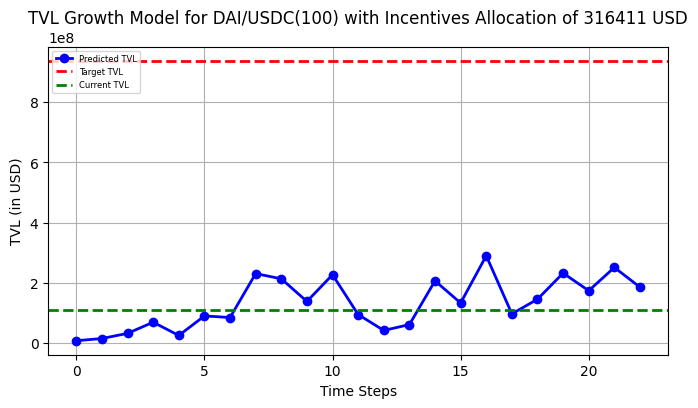

1/1 [==============================] - 0s 36ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


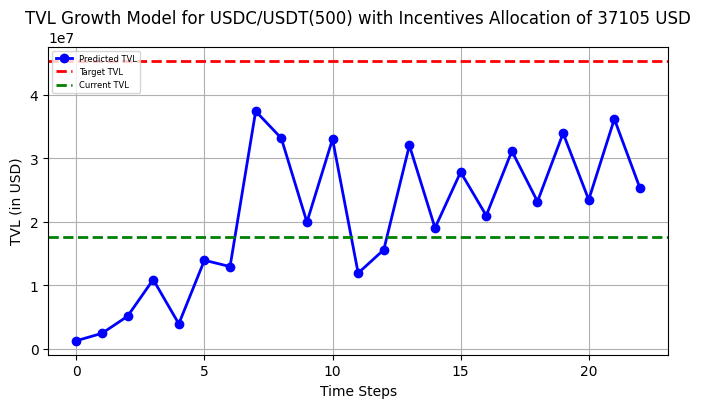

1/1 [==============================] - 0s 35ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


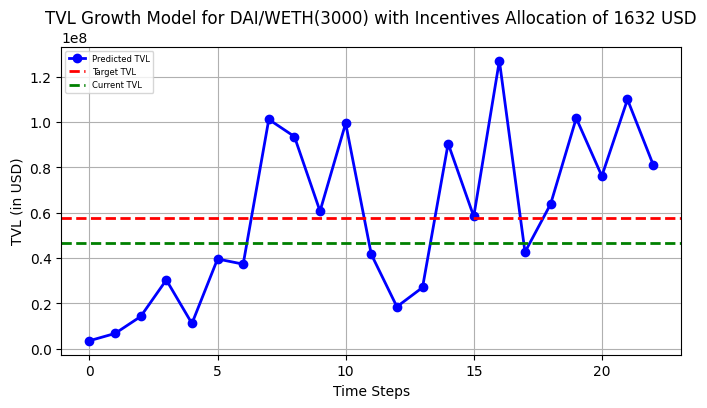

1/1 [==============================] - 0s 42ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


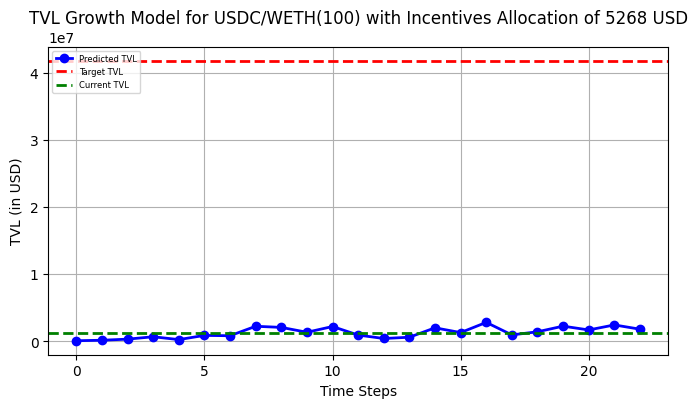

1/1 [==============================] - 0s 39ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


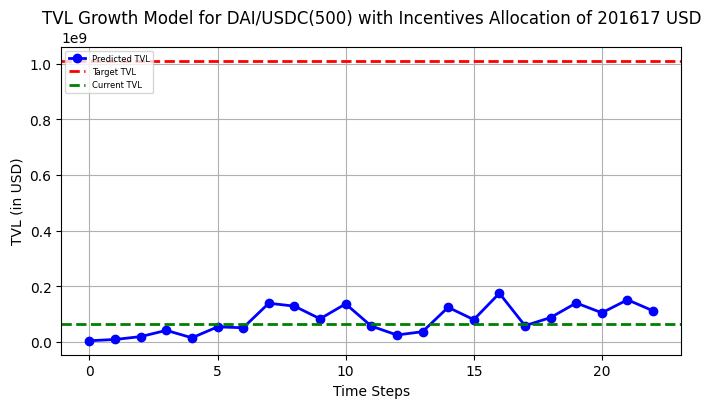

1/1 [==============================] - 0s 31ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


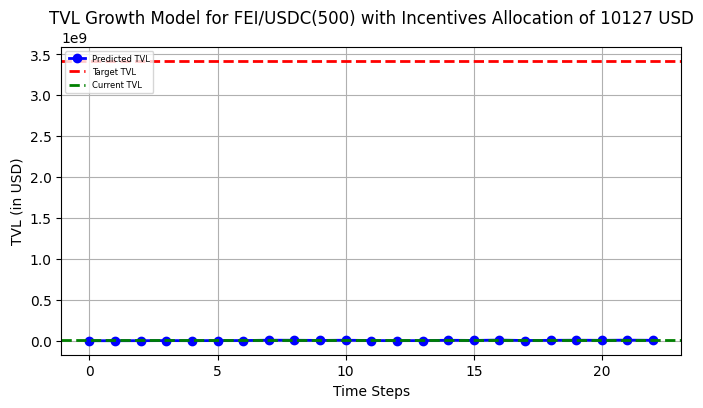

1/1 [==============================] - 0s 34ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


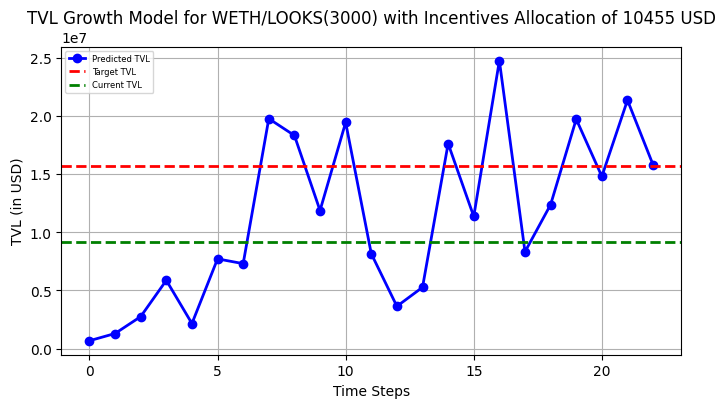

1/1 [==============================] - 0s 28ms/step


C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_15000\2939547040.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)


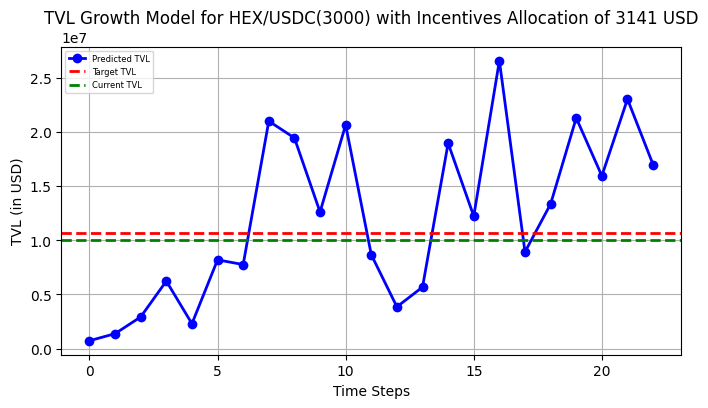

,pool_name,avg_feesUSD,avg_tvlUSD,adv,daily_roi,monthly_roi,annual_roi,incentive_allocation,target_tvl,estimated_tvl,mean_predicted_tvl
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC/WETH(3000),27694.939323,2.804378e+08,9.231646e+06,9.928210e-05,0.002983,0.036901,88692.568087,3.376531e+08,3.079180e+08,3.551231e+08
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,WBTC/WETH(3000),25325.055429,2.832811e+08,8.441685e+06,8.923572e-05,0.002681,0.033106,190271.581815,3.933370e+08,3.223544e+08,3.562229e+08
0x5777d92f208679db4b9778590fa3cab3ac9e2168,DAI/USDC(100),1395.457386,1.094057e+08,1.395457e+07,1.273950e-05,0.000382,0.004661,316411.683890,9.372891e+08,1.095404e+08,1.327610e+08
0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC/USDT(500),1017.413574,1.768922e+07,2.034827e+06,5.492990e-05,0.001649,0.020251,37105.096138,4.538071e+07,2.288200e+07,2.066006e+07
0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,DAI/WETH(3000),5011.745362,4.652558e+07,1.670582e+06,1.079079e-04,0.003242,0.040170,1632.524298,5.781205e+07,5.730854e+07,5.812300e+07
0xe0554a476a092703abdb3ef35c80e0d76d32939f,USDC/WETH(100),5.410061,1.251895e+06,5.410061e+04,4.377685e-06,0.000131,0.001599,5268.850107,4.179472e+07,1.678269e+06,1.283616e+06
0x6c6bc977e13df9b0de53b251522280bb72383700,DAI/USDC(500),468.438320,6.589392e+07,9.368766e+05,7.110772e-06,0.000213,0.002599,201617.946803,1.010975e+09,6.594319e+07,8.028229e+07
0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,FEI/USDC(500),0.306727,3.105674e+06,6.134533e+02,9.876236e-08,0.000003,0.000036,10127.630593,3.421276e+09,3.099190e+06,3.840169e+06
0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011,WETH/LOOKS(3000),708.354342,9.199308e+06,2.361181e+05,7.787596e-05,0.002339,0.028831,10455.354302,1.568986e+07,1.121969e+07,1.131567e+07
0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5,HEX/USDC(3000),1003.700457,1.004438e+07,3.345668e+05,9.797780e-05,0.002944,0.036407,3141.097776,1.066469e+07,9.597563e+06,1.212466e+07


In [33]:
mean_predicted_tvl_df = pd.DataFrame(columns=['pool_id', 'mean_predicted_tvl'])
predicted_tvl_df = pd.DataFrame()

for pool_id in filtered_pool_ids:

        test_data= uniswap_pools_daily_data[pool_id]

        # Prepare scaled data
        #test_sequence=prepare_test_data_scaled(test_data,tw)
        test_sequence=prepare_test_data(test_data,tw)
        predicted_tvl = model.predict(test_sequence)

        original_shape = predicted_tvl.shape
        predicted_tvl = predicted_tvl.reshape(-1, 1)
        # Inverse transform
        #predicted_tvl = scaler_all.inverse_transform(predicted_tvl)
            
        mean_predicted_tvl = np.mean(predicted_tvl)
        predicted_tvl_df[pool_id] = predicted_tvl.flatten()
        mean_predicted_tvl_df = mean_predicted_tvl_df.append({'pool_id': pool_id, 'mean_predicted_tvl': mean_predicted_tvl}, ignore_index=True)
        plot_predicted_tvl(predicted_tvl, target_tvl=df_target_tvl.loc[pool_id, 'target_tvl'], current_tvl= filtered_pools_df.loc[pool_id, 'avg_tvlUSD'],incentives=df_incentives.loc[pool_id,'incentive_allocation'], pool_name=filtered_pools_df.loc[pool_id,'pool_name'])
        
mean_predicted_tvl_df.set_index('pool_id', inplace=True)
resultant_df = pd.concat([filtered_pools_df, df_incentives, df_target_tvl, estimated_tvl_df, mean_predicted_tvl_df], axis=1)
resultant_df


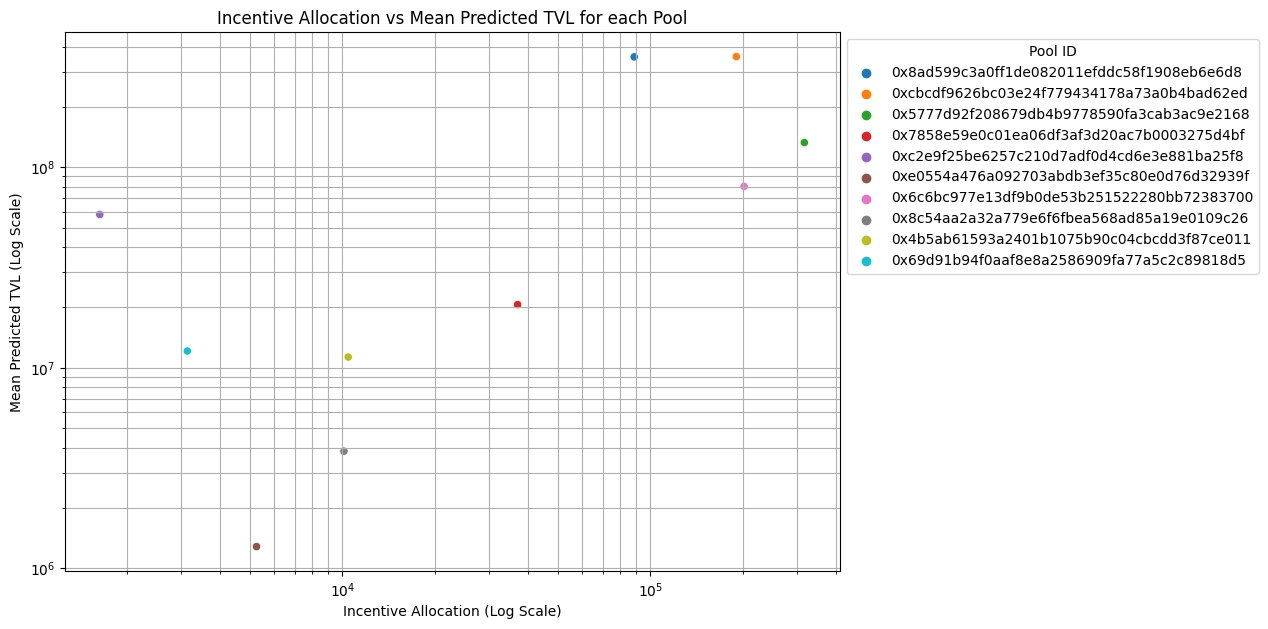

In [34]:
# Scatterplot of Incentive Allocation vs Mean Predicted TVL

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(x='incentive_allocation', y='mean_predicted_tvl', data=resultant_df, hue=resultant_df.index)
scatter.set(xscale="log", yscale="log")
plt.title('Incentive Allocation vs Mean Predicted TVL for each Pool')
plt.xlabel('Incentive Allocation (Log Scale)')
plt.ylabel('Mean Predicted TVL (Log Scale)')
plt.legend(title='Pool ID', bbox_to_anchor=(1,1), loc='upper left')
plt.grid(True, which="both", ls="-")
plt.show()


In [ ]:
#resultant_df.to_csv('resultant_df.csv',index=True)

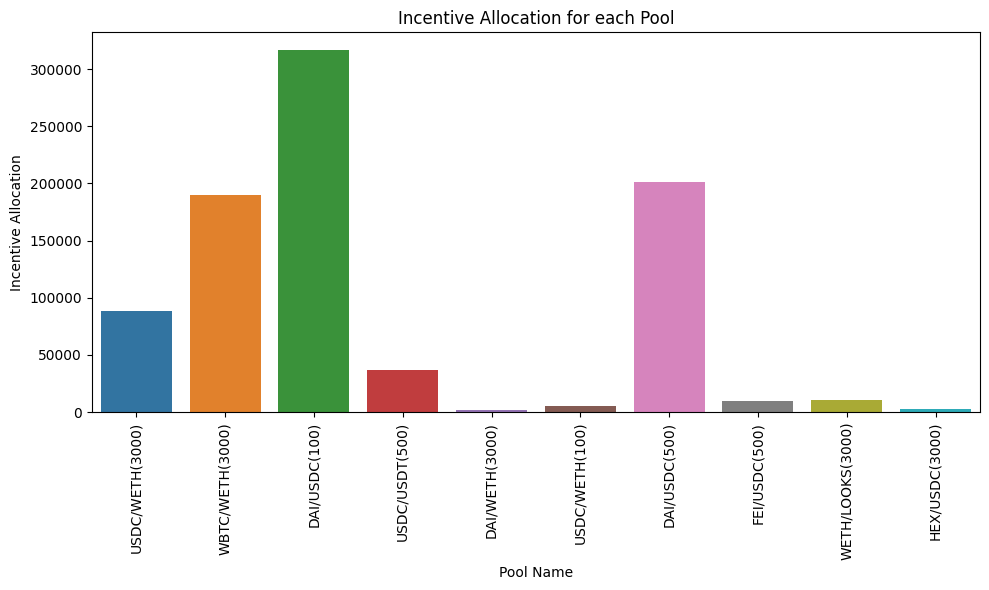

In [35]:
# Bar plot of incentive allocation for each pool
plt.figure(figsize=(10, 6))
sns.barplot(x='pool_name', y='incentive_allocation', data=resultant_df)
plt.title('Incentive Allocation for each Pool')
plt.xlabel('Pool Name')
plt.ylabel('Incentive Allocation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


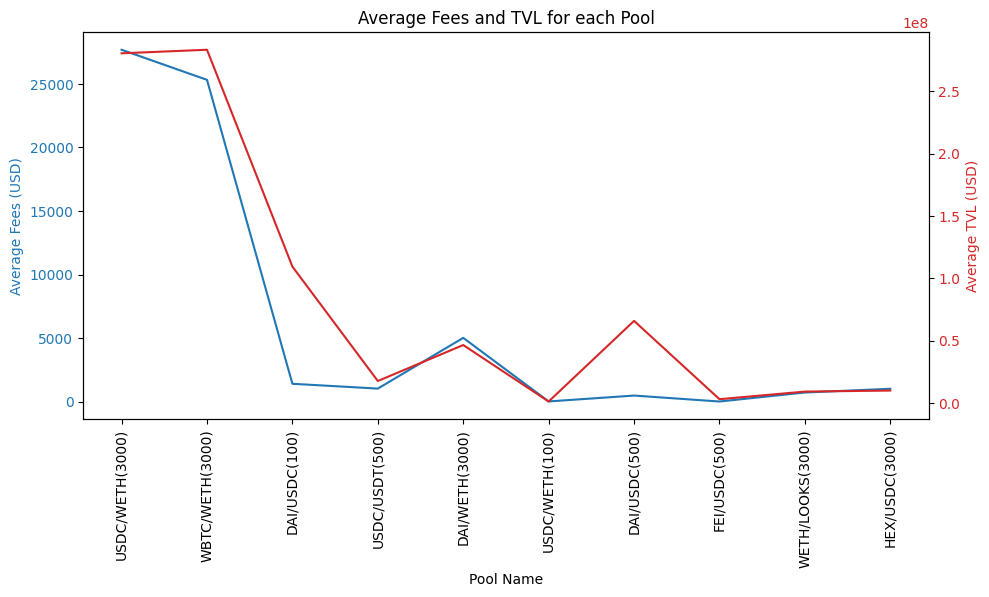

In [36]:
# Line plot of average fees and average TVL for each pool
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Pool Name')
ax1.set_ylabel('Average Fees (USD)', color=color)
ax1.plot(resultant_df['pool_name'], resultant_df['avg_feesUSD'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average TVL (USD)', color=color)
ax2.plot(resultant_df['pool_name'], resultant_df['avg_tvlUSD'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Average Fees and TVL for each Pool')
plt.show()


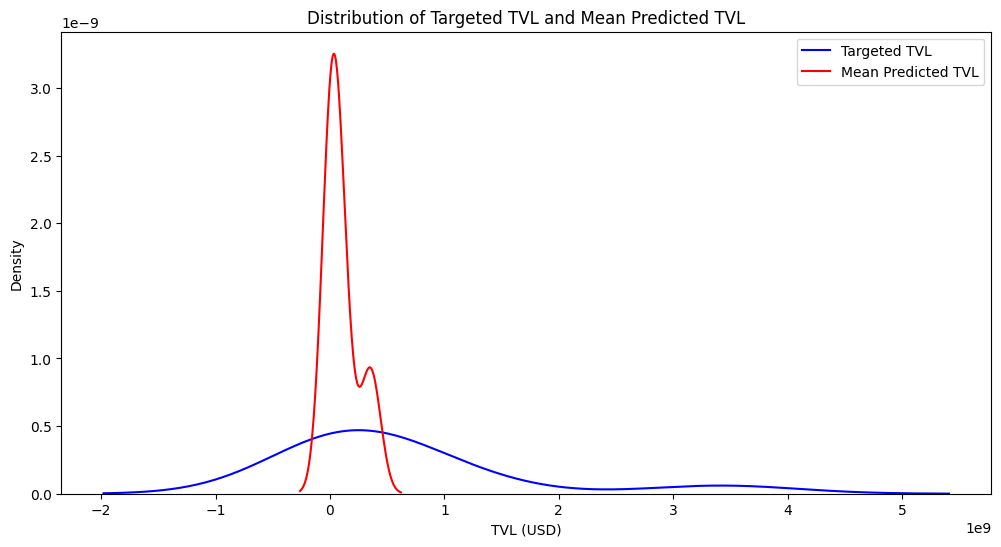

In [37]:
# Let's plot the distribution of targeted TVL and mean predicted TVL
plt.figure(figsize=(12, 6))
sns.kdeplot(resultant_df['target_tvl'], color='blue', label='Targeted TVL')
sns.kdeplot(resultant_df['mean_predicted_tvl'], color='red', label='Mean Predicted TVL')
plt.xlabel('TVL (USD)')
plt.ylabel('Density')
plt.title('Distribution of Targeted TVL and Mean Predicted TVL')
plt.legend()
plt.show()
